# CatBoost Tuning Phase 1 - Exploration

After deciding on using a CatBoost model, we will now investigate the different hyperparameters which can be tuned and the tuning ranges to explore in Phase 2.

We are no longer working with the original dataset and will be working directly with the synthetically-generated competition dataset. This dataset can be found [here](https://www.kaggle.com/competitions/playground-series-s5e6/data) on Kaggle and is licensed under CC0: Public Domain.

The primary goal of this phase is to explore a broad but computationally feasible range of hyperparameter values. The most promising ranges identified here will guide a more refined tuning in Phase 2.

We will use the optuna package to tune our hyperparameters values for our CatBoost model. This tuning process does take quite some time to run (~ 2 hours), we will save the best parameter results from the tuning into a `.json` file.

## Tuning Preparation

In [ ]:
import time
import json

# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preparation
from sklearn.preprocessing import LabelEncoder

# Modelling
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

# Hyperparameter Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

# Custom Functions -> Function definitions can be found in utils.py file
from utils import MAP3, generate_model_rankings

In [ ]:
# Set seeds for reproducibility
sampler_seed = 346346
split_seed = 4326
model_seed = 36209436

In [3]:
# Read in the training data
train = pd.read_csv('Data/train.csv', index_col='id')
train = train.rename(columns={'Temparature':'Temperature'})
train.head()

,Temperature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [ ]:
# Store the numeric and categorical columns
numeric_cols = ['Temperature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
categorical_cols = ['Soil Type', 'Crop Type']

# Extract feature columns and the target column
features = numeric_cols + categorical_cols
cat_cols_idxs = [int(inx) for inx in np.where(np.isin(features, categorical_cols))[0]] # The indices of the categorical columns
target = 'Fertilizer Name'

In [5]:
# Fit LabelEncoder to the target
le = LabelEncoder()
le.fit(train[target])
class_mapping = list(le.classes_)
class_mapping

['10-26-26', '14-35-14', '17-17-17', '20-20', '28-28', 'DAP', 'Urea']

In [ ]:
# Tune on a subsample of the data to reduce computation time - 5% should be a sufficient as a representative sample
tuning_data = train.sample(frac=0.05, random_state=sampler_seed)

## Optuna Tuning

In [ ]:
# Define an objective function for optuna to optimize
fixed_params = {'boosting_type':'Ordered', 'loss_function':'MultiClass'}

def objective(trial: Trial, num_folds: int) -> float:
    """
    Objective function for Optuna hyperparameter tuning of a CatBoostClassifier using Stratified K-Fold cross-validation.

    This function defines the search space, samples hyperparameters for each trial,
    trains and evaluates the model using stratified cross-validation, uses early stopping in the training, 
    and returns the average MAP@3 score across all folds.

    Parameters
    ----------
    trial : Trial
        An Optuna Trial object used to suggest hyperparameters.
    num_folds : int
        The number of folds to use in Stratified K-Fold Cross-Validation.

    Returns
    -------
    float
        The average MAP@3 score across all cross-validation folds.
    """

    # Suggest the bootstrap_type first as other parameters are conditional on it
    bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])
    
    # Suggest the bagging_temp and subsample first as multivariate=True depends on it
    bagging_temp = trial.suggest_float('bagging_temperature', 1e-10, 10.0, log=True)
    subsample = trial.suggest_float('subsample', 0.05, 1.0)

    # Suggest remaining unconditional parameters
    hyperparameters = {
        'iterations':300, # Fix at 300 for early model tuning
        'learning_rate':trial.suggest_float('learning_rate', 0.001, 0.3, log=True), # log = True apparently biases Optuna toward better values
        'depth':trial.suggest_int('depth', 3, 10), # Set the maximum depth to 10 to avoid long trial runtimes, but to still see if depth is important
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 0.8), # Set the maximum colsample_bylevel to 0.8 to avoid long trial runtimes
        'min_data_in_leaf':trial.suggest_int('min_data_in_leaf', 1, 100),
        'l2_leaf_reg':trial.suggest_float('l2_leaf_reg', 1.0, 5.0, log=True),
        'random_strength':trial.suggest_float('random_strength', 0.0, 1.0),
        'od_type':trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait':trial.suggest_int('od_wait', 10, 50),
        'bootstrap_type':bootstrap_type,
        'boosting_type':fixed_params['boosting_type'], # From early study results, it is clear that the boosting_type should be ordered. We don't need to explore this as thoroughly as the other variables
        'loss_function':fixed_params['loss_function'],
        'allow_writing_files': False, # Unless you want to analyze the report
        'random_seed': model_seed
    }

    # Add `bagging_temperature` only for Bayesian bootstrap
    if bootstrap_type == 'Bayesian':
        hyperparameters['bagging_temperature'] = bagging_temp
    # Add `subsample` only for Bernoulli or MVS bootstrap
    elif bootstrap_type in ['Bernoulli', 'MVS']:
        hyperparameters['subsample'] = subsample

    # Training-Test Split with Stratified K-Fold Cross-Validation
    sk_folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=split_seed)

    # Get the features and the target
    X, y = tuning_data[features], tuning_data[target]

    # Initialize a list to keep track of the scores
    MAP3_folds_scores = []

    # Loop through the folds and get the MAP3 fold scores
    for train_indices, valid_indices in sk_folds.split(X, y):
        # Get the training features and target observations
        X_train_tune, y_train_tune = X.iloc[train_indices], y.iloc[train_indices]
        y_train_tune_encoded = le.transform(y_train_tune)

        # Get the test features and target observations
        X_valid_tune, y_valid_tune = X.iloc[valid_indices], y.iloc[valid_indices]
        y_valid_tune_encoded = le.transform(y_valid_tune)

        # Initialize the CatBoost model
        model = CatBoostClassifier(**hyperparameters, cat_features=cat_cols_idxs)

        # Fit the model on the training fold data
        model.fit(X_train_tune, 
                  y_train_tune_encoded,
                  eval_set=(X_valid_tune, y_valid_tune_encoded),
                  early_stopping_rounds=hyperparameters['od_wait'],
                  verbose=0)

        # Get the model rankings for the validation fold
        valid_fold_rankings = generate_model_rankings(model, X_valid_tune, class_mapping)

        # Compute the MAP3 score for this fold
        MAP3_fold_score = MAP3(labels=y_valid_tune, rankings=valid_fold_rankings)

        # Add the MAP3 score to the list of fold scores
        MAP3_folds_scores.append(MAP3_fold_score)

    # Return the average MAP3 score across all folds
    return np.mean(MAP3_folds_scores)

### Sources:
# - https://www.datacamp.com/tutorial/optuna
# - https://www.kaggle.com/code/tasnimniger/tune-a-catboostclassifier-model-with-optuna
# - https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/
# - https://www.kaggle.com/code/egorphysics/catboost-optuna-optimisation
# - https://www.w3schools.com/python/python_ml_cross_validation.asp

In [8]:
# Study parameters
trials = 200
start_up_trials = trials // 10 + 1
warmup_steps = 50
num_folds = 3
sampler = TPESampler(multivariate=True, seed=sampler_seed) # Multivariate=True means considers "dependencies of hyperparameters during optimization" - https://medium.com/optuna/multivariate-tpe-makes-optuna-even-more-powerful-63c4bfbaebe2
pruner = MedianPruner(n_startup_trials=start_up_trials, n_warmup_steps=warmup_steps)

# Study
study = optuna.create_study(
    direction='maximize', 
    pruner=pruner, 
    sampler=sampler,
    study_name='CatBoost_Tuning_Phase1'
)

# Run and time the study
start = time.time()
study.optimize(lambda trial: objective(trial, num_folds), n_trials=trials, timeout=7200) # Run 200 trials or stop after 2 hours
end = time.time()

# Print the total runtime
print('-----------------------------------------------------------')
print(f'Hyperparameter Tuning Runtime: {(end-start)/60:.2f} minutes.')

[I 2025-06-26 12:41:30,605] A new study created in memory with name: CatBoost_Tuning_Phase1
[I 2025-06-26 12:41:53,945] Trial 0 finished with value: 0.28421777777777774 and parameters: {'bootstrap_type': 'MVS', 'bagging_temperature': 6.2001779991879726e-06, 'subsample': 0.09138419995630612, 'learning_rate': 0.006207107247569148, 'depth': 6, 'colsample_bylevel': 0.20796318656065466, 'min_data_in_leaf': 98, 'l2_leaf_reg': 3.3148341382083104, 'random_strength': 0.883144702535295, 'od_type': 'IncToDec', 'od_wait': 39}. Best is trial 0 with value: 0.28421777777777774.
[I 2025-06-26 12:42:06,521] Trial 1 finished with value: 0.28864 and parameters: {'bootstrap_type': 'MVS', 'bagging_temperature': 0.00035495333274965213, 'subsample': 0.1886730423158563, 'learning_rate': 0.059774504825516134, 'depth': 6, 'colsample_bylevel': 0.378895932221675, 'min_data_in_leaf': 56, 'l2_leaf_reg': 1.7652891555296786, 'random_strength': 0.0678417635387436, 'od_type': 'Iter', 'od_wait': 14}. Best is trial 1 wit

-----------------------------------------------------------
Hyperparameter Tuning Runtime: 108.34 minutes.


In [9]:
# Save the best trial
best_trial = study.best_trial

# Save best parameters
best_params = best_trial.params
# Include the fixed parameters
for key, value in fixed_params.items():
    best_params[key] = value

# Exclude the impermissible hyperparameter combinations
if best_params['bootstrap_type'] == 'Bayesian':
    best_params.pop('subsample')
elif best_params['bootstrap_type'] in ['MVS', 'Bernoulli']:
    best_params.pop('bagging_temperature')

# Save the study's best parameters to a file
with open('Study_Results/Phase1/best_params.json', 'w') as file:
    json.dump(best_params, file)

# Print the results
print(f'Best MAP@3: {study.best_value:.4f} achieved in Trial #{best_trial.number}')
print(f'Best hyperparameters: {best_params}')

# Save the od_wait parameter for later use
od_wait = best_params.pop('od_wait')

Best MAP@3: 0.2906 achieved in Trial #160
Best hyperparameters: {'bootstrap_type': 'Bernoulli', 'subsample': 0.5656247419496974, 'learning_rate': 0.027816293131505784, 'depth': 10, 'colsample_bylevel': 0.5396698901117247, 'min_data_in_leaf': 85, 'l2_leaf_reg': 2.3595944761366017, 'random_strength': 0.008179345523639161, 'od_type': 'IncToDec', 'od_wait': 46, 'boosting_type': 'Ordered', 'loss_function': 'MultiClass'}


## Tuning Results

**Best Hyperparameter Selection - Phase 1**
- depth: 10
- learning_rate: 0.027816293131505784
- bootstrap_type: Bernoulli
- colsample_bylevel: 0.5396698901117247
- min_data_in_leaf: 85
- subsample: 0.5656247419496974
- random_strength: 0.008179345523639161
- l2_leaf_reg: 2.3595944761366017
- boosting_type: Ordered
- loss_function: MultiClass
- od_type: IncToDec
- od_wait: 46

In [10]:
# Examine the top 20 trials
top20_trials = sorted(study.trials, key=lambda trial: trial.value, reverse=True)[:20]
for i, trial in enumerate(top20_trials):
    print(f'MAP@3 = {trial.value:.4f} achieved on Trial #{trial.number} with parameters: {trial.params}')

MAP@3 = 0.2906 achieved on Trial #160 with parameters: {'bootstrap_type': 'Bernoulli', 'bagging_temperature': 3.851579501966772e-05, 'subsample': 0.5656247419496974, 'learning_rate': 0.027816293131505784, 'depth': 10, 'colsample_bylevel': 0.5396698901117247, 'min_data_in_leaf': 85, 'l2_leaf_reg': 2.3595944761366017, 'random_strength': 0.008179345523639161, 'od_type': 'IncToDec', 'od_wait': 46}
MAP@3 = 0.2904 achieved on Trial #169 with parameters: {'bootstrap_type': 'Bernoulli', 'bagging_temperature': 0.0017887353217498675, 'subsample': 0.415884173862209, 'learning_rate': 0.10650231271827791, 'depth': 9, 'colsample_bylevel': 0.5062042152667681, 'min_data_in_leaf': 94, 'l2_leaf_reg': 2.724816942419469, 'random_strength': 0.20145999287004346, 'od_type': 'IncToDec', 'od_wait': 47}
MAP@3 = 0.2904 achieved on Trial #198 with parameters: {'bootstrap_type': 'MVS', 'bagging_temperature': 0.05348070534075387, 'subsample': 0.29019483388436895, 'learning_rate': 0.09549234266440819, 'depth': 10, '

In [17]:
# Put the top 20 trials into a dataframe
top20_df = pd.DataFrame([trial.params for trial in top20_trials])
top20_df['MAP@3'] = pd.Series([trial.value for trial in top20_trials])
top20_df

,bootstrap_type,bagging_temperature,subsample,learning_rate,depth,colsample_bylevel,min_data_in_leaf,l2_leaf_reg,random_strength,od_type,od_wait,MAP@3
0,Bernoulli,0.000039,0.565625,0.027816,10,0.539670,85,2.359594,0.008179,IncToDec,46,0.290569
1,Bernoulli,0.001789,0.415884,0.106502,9,0.506204,94,2.724817,0.201460,IncToDec,47,0.290413
2,MVS,0.053481,0.290195,0.095492,10,0.467169,85,1.321551,0.026053,IncToDec,38,0.290396
3,MVS,0.001479,0.133964,0.045747,10,0.367118,78,1.017504,0.292761,Iter,49,0.290356
4,Bayesian,0.001172,0.129987,0.137798,7,0.341303,88,2.121548,0.153550,Iter,27,0.290196
5,MVS,0.001206,0.249499,0.071428,10,0.422998,65,1.241783,0.020826,IncToDec,40,0.290160
6,MVS,5.233089,0.067839,0.018388,8,0.421443,61,2.844166,0.057853,Iter,31,0.290116
7,Bayesian,0.000333,0.364255,0.118754,6,0.271586,86,1.947605,0.112212,Iter,25,0.290027
8,MVS,0.428232,0.139482,0.018944,9,0.411890,73,3.179784,0.215053,IncToDec,23,0.289929
9,MVS,0.002136,0.066032,0.032433,8,0.531020,87,2.096338,0.173365,Iter,38,0.289871


- Note: bagging_temperature when used with Bayesian typically had low values - around 0.00051033

- Note: subsample when used with MVS or Bernoulli typically had values ranging from 0.059745 to 0.654666 - the best trial had subsample set to 0.565625

In [18]:
# Get a sense of the value ranges for the numeric parameters
top20_df.describe()

,bagging_temperature,subsample,learning_rate,depth,colsample_bylevel,min_data_in_leaf,l2_leaf_reg,random_strength,od_wait,MAP@3
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.698100,0.262470,0.062484,8.700000,0.440554,74.000000,2.211148,0.124218,37.650000,0.289861
std,1.818428,0.189996,0.048449,1.592747,0.102342,17.296182,0.937844,0.119593,8.957649,0.000431
min,0.000006,0.059745,0.012632,5.000000,0.257121,22.000000,1.017504,0.008179,23.000000,0.289147
25%,0.000247,0.094449,0.027233,8.000000,0.362224,68.000000,1.424778,0.038219,29.250000,0.289480
50%,0.001326,0.237612,0.039090,9.000000,0.435565,77.500000,2.108943,0.095037,39.500000,0.289862
75%,0.147168,0.377260,0.098245,10.000000,0.533183,86.250000,2.754654,0.180388,45.250000,0.290169
max,6.607933,0.654666,0.181596,10.000000,0.610059,94.000000,4.638287,0.505170,49.000000,0.290569


- learning_rate range: [0.012632, 0.159382] with a mean of 0.062484
- depth range: [6, 10] with a mean of 8.700000
- colsample_bylevel range: [0.257121, 0.610059] with a mean of 0.440554
- subsample range: [0.000006, 0.642462] with a mean of 0.262470
- min_data_in_leaf range: [39, 94] with a mean of 74
- l2_leaf_reg range: [1.017504, 4.086836] with a mean of 2.211148
- random_strength range: [0.008179, 0.363404] with a mean of 0.124218
- od_wait range: [20, 49] with an mean of 37.650000

In [19]:
# Get the frequency counts of the categorical data
print(top20_df['bootstrap_type'].value_counts())
print(top20_df['od_type'].value_counts())

bootstrap_type
MVS          11
Bernoulli     6
Bayesian      3
Name: count, dtype: int64
od_type
Iter        12
IncToDec     8
Name: count, dtype: int64


Bootstrap Type:
- MVS occurs the most frequently in the top 20 trials; however, the best two trials in the study use Bernoulli, so we will keep Bernoulli too.
- Bayesian occurs relatively infrequently and has a long runtime, so let's drop Bayesian from the Bootstrap in phase 2.
- Removing Bayesian also allows the Multivariate parameter of the study to work more efficiently.

Od_Type:
- There is no apparent reason to prefer Iter of IncToDec, so let's keep both for phase 2.

In [20]:
# Save study trial results
study_dataframe = study.trials_dataframe()
study_dataframe.to_csv('Study_Results/Phase1/trials.csv')

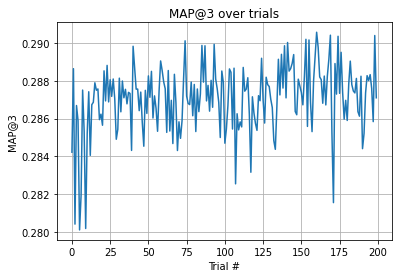

In [21]:
# Examine top trial results and performance trend
study_dataframe['value'].plot(title='MAP@3 over trials', xlabel='Trial #', ylabel='MAP@3')
plt.grid(True)
plt.show()

The appears to be lots of fluctuations, however the range of average MAP@3 scores (the y-axis) is quite small. Also, we only used 5% of the dataset and 3-fold cross-validation, therefore, randomness in model performance needs to be taken into account.

In [22]:
# An interactive version of the plot above
plot_optimization_history(study).show()

In [23]:
# Plot Paramerter Importances
plot_param_importances(study).show()

This plot tells us that fine tuning the learning rate parameter is the most important, along with random strength, colsample_bylevel, and od_wait, and subsample, so let's ensure we focus on these in phase 2.

Learning rate is very important, explaining 48% of the variation in MAP@3.

Tuning bagging_temperature, bootstrap_type, od_type isn't as important.

Since od_type is not that important, let's fix it to 'IncToDec', as it was in the top 3 trials.

In [ ]:
# Plot Multivariate Visualization
plot_parallel_coordinate(study).show()

## Notes:
# - Each line is a trial
# - X-axis has the hyperparameters
# - Y-axis is the hyperparameter value
# - Colour Shade is the Objective Value
# - See which parameter ranges tend to result in better scores

We can see favourtism for MVS, medium range colsample_bylevel, high depth, medium learning rates, higher min_data_in_leaf, low random strength values, and low subsample values.

## Conclusion

For phase 2, we are going to narrow the search range and allow for increased depths and larger colsample_bylevel values. We are also going to increase the number of iterations each trial and run 5-fold cross validation.